# Iterative Solvers

In [1]:
import numpy as np
import sympy as sy
import matplotlib.pyplot as plt
import time
import scipy.stats as stats
import scipy.optimize as opt
import scipy.integrate as intgr
import scipy.linalg as la
from scipy import sparse

### Problem 1

In [2]:
def jacobi(A, b, tol, maxiters):
    n,n = np.shape(A)
    d = np.diagonal(A)
    x0 = np.zeros(n)
    dist=1
    iter=0 
    while (dist>tol) & (iter < maxiters):
        x = x0 + (b - A@x0)/d
        dist = la.norm(x - x0, ord = np.inf)
        x0 = x
        iter +=1
    return x

def diag_dom(n, num_entries=None):
    '''
    Generate a strictly diagonally dominant (n, n) matrix.
    Parameters:
        n (int): The dimension of the system.
        num_entries (int): The number of nonzero values.
            Defaults to n^(3/2)-n.
    Returns:
        A ((n,n) ndarray): A (n, n) strictly diagonally dominant matrix.
    '''
    if num_entries is None:
        num_entries = int(n**1.5) - n
    A = np.zeros((n,n))
    rows = np.random.choice(np.arange(0,n), size=num_entries)
    cols = np.random.choice(np.arange(0,n), size=num_entries)
    data = np.random.randint(-4, 4, size=num_entries)
    for i in range(num_entries):
        A[rows[i], cols[i]] = data[i]
    for i in range(n):
        A[i,i] = np.sum(np.abs(A[i])) + 1
    return A

A = diag_dom(10)
b = np.random.random(10)
x = jacobi(A, b, 1e-8, 500)
if np.allclose(b,A@x):
    print("Ax^k and b are close\n")
print("X= ", x)

Ax^k and b are close

X=  [ 0.5169057   0.24320545  0.30051953  0.04421933  0.03760439  0.1756432
  0.22667248 -0.02149561  0.23854771  0.03836586]


### Problem 2

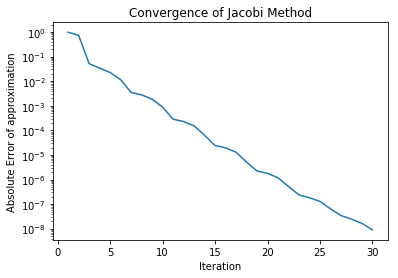

In [3]:
def jacobi_2(A, b, tol, maxiters, plot= False):
    n,n = np.shape(A)
    d = np.diagonal(A)
    x0 = np.zeros(n)
    dist=1
    iter=0
    err = np.empty(0)
    while (dist>tol) & (iter < maxiters):
        x = x0 + (b - A@x0)/d
        dist = la.norm(x - x0, ord = np.inf)
        err = np.append(err, dist)
        x0 = x
        iter +=1
    if plot==True:
        iteration = np.linspace(1, len(err), len(err))
        plt.plot(iteration, err)
        plt.yscale('log')
        plt.xlabel("Iteration")
        plt.ylabel("Absolute Error of approximation")
        plt.title("Convergence of Jacobi Method")
        plt.show()
    return x, err

# Use the diag_dom function from problem 1
A = diag_dom(10)
b = np.random.random(10)
x,error= jacobi_2(A, b, 1e-8, 500, True)

### Problem 3

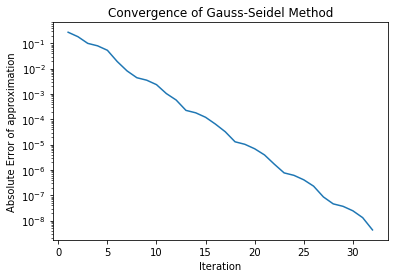

In [4]:
def GaussSeidel(A, b, tol, maxiters, plot= False):
    n,n = np.shape(A)
    dist = 1
    iter = 0
    errors = np.empty(0)
    x0 = np.zeros(n)
    while (dist>tol) & (iter<maxiters):
        x = np.copy(x0)
        for i in range(n):
            x[i] = x0[i]+ (1/A[i,i])*(b[i] - (A[i,:]).T@x0)
        dist = la.norm(x-x0, ord=np.inf)
        errors = np.append(errors, dist)
        iter +=1
        x0 = x
    if plot==True:
        iteration = np.linspace(1, len(errors), len(errors))
        plt.plot(iteration, errors)
        plt.yscale('log')
        plt.xlabel("Iteration")
        plt.ylabel("Absolute Error of approximation")
        plt.title("Convergence of Gauss-Seidel Method")
        plt.show()
    return x,errors

# Use the diag_dom function from problem 1
A = diag_dom(10)
b = np.random.random(10)
x,errors= GaussSeidel(A, b, 1e-8,500, True)

### Problem 4

In [5]:
def GaussSeidel2(A, b, tol, maxiters):
    n,n = np.shape(A)
    dist = 1
    iter = 0
    errors = np.empty(0)
    x0 = np.zeros(n)
    while (dist>tol) & (iter<maxiters):
        x = np.copy(x0)
        for i in range(n):
            rowstart = A.indptr[i]
            rowend = A.indptr[i+1]
            x[i] = x0[i]+ (1/A[i,i])*(b[i] - A.data[rowstart:rowend]@x0[A.indices[rowstart:rowend]])
        dist = la.norm(x-x0, ord=np.inf)
        errors = np.append(errors, dist)
        iter +=1
        x0 = x
    return x,errors

# Use the diag_dom function from problem 1
A = sparse.csr_matrix(diag_dom(5000))
b = np.random.random(5000)
x,errors = GaussSeidel2(A, b, 1e-8, 500)
if np.allclose(b,A@x):
    print("Ax^k and b are close\n")
print("X= ", x)

X=  [0.00326296 0.00532161 0.00200195 ... 0.00777173 0.00698177 0.00533859]


### Problem 5

In [6]:
def SOR(A, b, omega, tol, maxiters):
    n,n = np.shape(A)
    dist = 1
    iter = 0
    errors = np.empty(0)
    x0 = np.zeros(n)
    while (dist>tol) & (iter<maxiters):
        x = np.copy(x0)
        for i in range(n):
            rowstart = A.indptr[i]
            rowend = A.indptr[i+1]
            x[i] = x0[i]+ (omega/A[i,i])*(b[i] - A.data[rowstart:rowend]@x0[A.indices[rowstart:rowend]])
        dist = la.norm(x-x0, ord=np.inf)
        errors = np.append(errors, dist)
        iter +=1
        x0 = x
    return x,errors,iter

# Use the diag_dom function from problem 1
A = sparse.csr_matrix(diag_dom(1000))
b = np.random.random(1000)
x,errors,iter = SOR(A, b, 1.2, 1e-8, 500)
if np.allclose(b,A@x):
    print("Ax^k and b are close\n")

### Problem 6

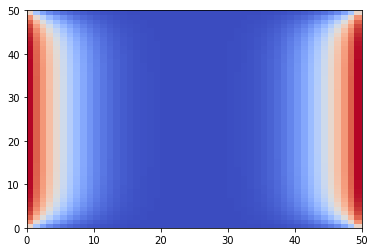

The number of iterations needed: 100


In [7]:
def fin_diff(n, omega, tol=10e-8, maxiters=100, plot=False):
    ones = np.ones(n-1)
    fours = -4*np.ones(n)
    B = np.diag(fours)
    np.fill_diagonal(B[1:], ones)
    np.fill_diagonal(B[:, 1:], ones)
    I = np.eye(n)
    BB = np.eye(n)
    II = np.zeros((n, n))
    np.fill_diagonal(II[1:], ones)
    np.fill_diagonal(II[:, 1:], ones)
    A = np.kron(II, I) + np.kron(BB, B)
    A_sparse = sparse.csr_matrix(A)
    b_tile = np.zeros(n)
    b_tile[0] = -100
    b_tile[-1] = -100
    b = np.tile(b_tile, n) 
    x,errors,iter = SOR(A_sparse, b, omega, tol=tol, maxiters=maxiters)
    if plot == True:
        x_grid = np.reshape(x, (n,n))
        plt.pcolormesh(np.linspace(0, n, n+1), np.linspace(0, n, n+1), x_grid, cmap='coolwarm')
        plt.show()
    return iter

# Call the function
iter = fin_diff(50, 1, plot=True)
print("The number of iterations needed:", iter)

### Problem 7

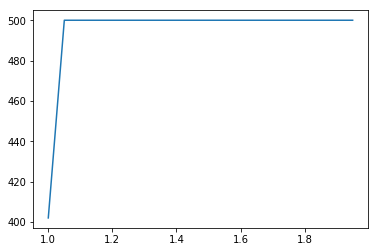

Omega=  1.0 needed least number of iterations (i.e 402.0 )


In [8]:
omega_vec = np.linspace(1, 1.95, 20)
n_iters = np.zeros_like(omega_vec)
for i, omega in enumerate(omega_vec):
    n_iters[i] = fin_diff(20, omega, tol=1e-2, maxiters=500, plot=False)
plt.plot(omega_vec, n_iters)
plt.show()
min_iters = np.min(n_iters)
omega_min = omega_vec[np.argmin(n_iters)]
print("Omega= ", omega_min, "needed least number of iterations (i.e", min_iters, ")")